In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import keras.backend as K
from keras.layers import Input, Dense, Activation, Dropout, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2

from smallVGG import *

Using TensorFlow backend.


In [2]:
path = 'image'
model_name = '80_classes_3conv_v1.model'

In [3]:
width, height, depth = 96, 96, 3

In [4]:
# create an image generator
data_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=25, 
                              width_shift_range=0.1,
                              height_shift_range=0.1, 
                              shear_range=0.2, 
                              zoom_range=0.2,
                              horizontal_flip=True, 
                              fill_mode="nearest",
                              validation_split = 0.2)

In [5]:
batch_size = 32

train_gen = data_gen.flow_from_directory(path, target_size = (width, height),
                                              batch_size = batch_size, class_mode = "categorical",
                                              subset = "training")
valid_gen = data_gen.flow_from_directory(path, target_size = (width, height),
                                             batch_size = batch_size, class_mode = "categorical",
                                             subset = "validation")

Found 13620 images belonging to 80 classes.
Found 3361 images belonging to 80 classes.


In [6]:
classes = len(train_gen.class_indices)

In [7]:
# model = SmallerVGGNet.build(width, height, depth, classes)
# model.summary()

In [17]:
def model(width, height, depth, classes):
    """
    Network Architecture:
    Conv2D -> BatchNorm -> RELU -> AvgPool -> Flatten -> softmax
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    
    Returns:
    model -- a Model() instance in Keras
    """
    K.clear_session()
    # define the input as a tensor with the shape input_shape
    input_X = Input((width, height, depth))
    
    X = Conv2D(64, (3, 3), strides = (2, 2), padding='same')(input_X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)    
#     X = Dropout(0.25)(X)
    
    X = Conv2D(64, (3, 3), strides = (2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)   
#     X = Dropout(0.25)(X)

    X = Conv2D(64, (3, 3), strides = (2, 2), padding='same')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2, 2))(X)   
#     X = Dropout(0.25)(X)

#     X = Conv2D(128, (3, 3), strides = (2, 2), padding='same')(X)
#     X = BatchNormalization()(X)
#     X = MaxPooling2D((2, 2))(X)
    
#     X = Conv2D(128, (3, 3), strides = (1, 1), padding='same')(X)
#     X = BatchNormalization()(X)
#     X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(1024, activation = "relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation = "softmax")(X)
    
    model = Model(inputs = input_X, outputs = X)
    
    return model

In [10]:
model = SmallerVGGNet.build(width, height, depth, classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [11]:
# model = model(width, height, depth, classes)
# model.summary()

In [12]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"]
             )

In [13]:
early_stopping = EarlyStopping(patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(model_name, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

In [14]:
train_history = model.fit_generator(train_gen,
                                    steps_per_epoch = int(len(train_gen)),
                                    validation_data = valid_gen,
                                    validation_steps = len(valid_gen),
                                    epochs = 50,
                                    callbacks = [early_stopping, model_checkpoint, reduce_lr])

Epoch 1/50
426/426 [==============================] - 254s 596ms/step - loss: 4.4698 - acc: 0.0962 - val_loss: 4.2552 - val_acc: 0.1583

Epoch 00001: val_loss improved from inf to 4.25518, saving model to 80_classes_3conv_v1.model
Epoch 2/50
426/426 [==============================] - 77s 180ms/step - loss: 3.7485 - acc: 0.1614 - val_loss: 3.0971 - val_acc: 0.2437

Epoch 00002: val_loss improved from 4.25518 to 3.09713, saving model to 80_classes_3conv_v1.model
Epoch 3/50
426/426 [==============================] - 77s 180ms/step - loss: 3.3038 - acc: 0.2227 - val_loss: 3.9627 - val_acc: 0.1907

Epoch 00003: val_loss did not improve from 3.09713
Epoch 4/50
426/426 [==============================] - 76s 179ms/step - loss: 3.0189 - acc: 0.2677 - val_loss: 2.8825 - val_acc: 0.2984

Epoch 00004: val_loss improved from 3.09713 to 2.88245, saving model to 80_classes_3conv_v1.model
Epoch 5/50
426/426 [==============================] - 77s 181ms/step - loss: 2.7686 - acc: 0.3025 - val_loss: 3.12

Text(0.5,0,'epoch')

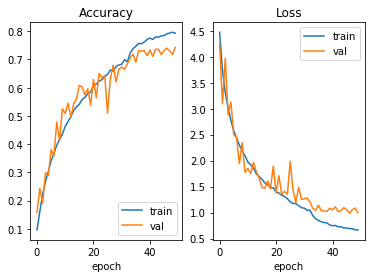

In [15]:
plt.subplot(1, 2, 1)
plt.plot(train_history.history["acc"])
plt.plot(train_history.history["val_acc"])
plt.title("Accuracy")
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel("epoch")

plt.subplot(1, 2, 2)
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel("epoch")

In [16]:
train_history2 = model.fit_generator(train_gen,
                                    steps_per_epoch = int(len(train_gen)),
                                    validation_data = valid_gen,
                                    validation_steps = len(valid_gen),
                                    epochs = 100,
                                    callbacks = [early_stopping, model_checkpoint, reduce_lr])

Epoch 1/100
426/426 [==============================] - 77s 182ms/step - loss: 0.6610 - acc: 0.7955 - val_loss: 1.1632 - val_acc: 0.7102

Epoch 00001: val_loss did not improve from 0.98669
Epoch 2/100
426/426 [==============================] - 75s 175ms/step - loss: 0.6421 - acc: 0.8071 - val_loss: 1.0608 - val_acc: 0.7263

Epoch 00002: val_loss did not improve from 0.98669
Epoch 3/100
426/426 [==============================] - 76s 179ms/step - loss: 0.6343 - acc: 0.8066 - val_loss: 1.0245 - val_acc: 0.7376

Epoch 00003: val_loss did not improve from 0.98669
Epoch 4/100
426/426 [==============================] - 74s 173ms/step - loss: 0.6337 - acc: 0.8054 - val_loss: 1.0304 - val_acc: 0.7406

Epoch 00004: val_loss did not improve from 0.98669
Epoch 5/100
426/426 [==============================] - 74s 174ms/step - loss: 0.6192 - acc: 0.8075 - val_loss: 1.0257 - val_acc: 0.7456

Epoch 00005: val_loss did not improve from 0.98669
Epoch 6/100
426/426 [==============================] - 75s 1

Text(0.5,0,'epoch')

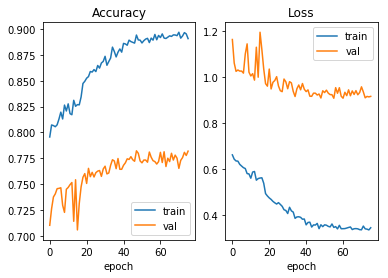

In [17]:
plt.subplot(1, 2, 1)
plt.plot(train_history2.history["acc"])
plt.plot(train_history2.history["val_acc"])
plt.title("Accuracy")
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel("epoch")

plt.subplot(1, 2, 2)
plt.plot(train_history2.history["loss"])
plt.plot(train_history2.history["val_loss"])
plt.title("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel("epoch")

In [44]:
train_history3 = model.fit_generator(train_gen,
                                    steps_per_epoch = int(len(train_gen)),
                                    validation_data = valid_gen,
                                    validation_steps = len(valid_gen),
                                    epochs = 25,
                                    callbacks = [early_stopping, model_checkpoint, reduce_lr])


Epoch 1/25
148/148 [==============================] - 20s 138ms/step - loss: 0.8631 - acc: 0.7325 - val_loss: 0.8310 - val_acc: 0.7453

Epoch 00001: val_loss did not improve from 0.80705
Epoch 2/25
148/148 [==============================] - 19s 131ms/step - loss: 0.8464 - acc: 0.7355 - val_loss: 1.1248 - val_acc: 0.6796

Epoch 00002: val_loss did not improve from 0.80705
Epoch 3/25
148/148 [==============================] - 19s 125ms/step - loss: 0.8011 - acc: 0.7601 - val_loss: 0.8239 - val_acc: 0.7547

Epoch 00003: val_loss did not improve from 0.80705
Epoch 4/25
148/148 [==============================] - 20s 133ms/step - loss: 0.8271 - acc: 0.7420 - val_loss: 0.8603 - val_acc: 0.7496

Epoch 00004: val_loss did not improve from 0.80705
Epoch 5/25
148/148 [==============================] - 20s 133ms/step - loss: 0.8188 - acc: 0.7506 - val_loss: 0.7777 - val_acc: 0.7660

Epoch 00005: val_loss improved from 0.80705 to 0.77766, saving model to 128_128.model
Epoch 6/25
148/148 [==========

Text(0.5,0,'epoch')

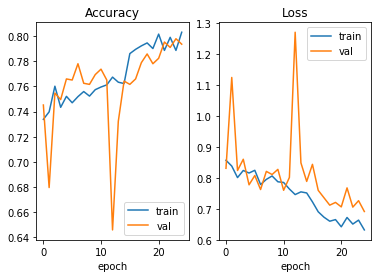

In [45]:
plt.subplot(1, 2, 1)
plt.plot(train_history3.history["acc"])
plt.plot(train_history3.history["val_acc"])
plt.title("Accuracy")
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel("epoch")

plt.subplot(1, 2, 2)
plt.plot(train_history3.history["loss"])
plt.plot(train_history3.history["val_loss"])
plt.title("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel("epoch")

In [26]:
train_history4 = model.fit_generator(train_gen,
                                    steps_per_epoch = int(len(train_gen)),
                                    validation_data = valid_gen,
                                    validation_steps = len(valid_gen),
                                    epochs = 50,
                                    callbacks = [early_stopping, model_checkpoint, reduce_lr])

Epoch 1/50
148/148 [==============================] - 25s 172ms/step - loss: 0.5142 - acc: 0.8347 - val_loss: 0.6132 - val_acc: 0.8359

Epoch 00001: val_loss did not improve from 0.60146
Epoch 2/50
148/148 [==============================] - 25s 166ms/step - loss: 0.5188 - acc: 0.8440 - val_loss: 0.6031 - val_acc: 0.8351

Epoch 00002: val_loss did not improve from 0.60146
Epoch 3/50
148/148 [==============================] - 24s 165ms/step - loss: 0.5214 - acc: 0.8440 - val_loss: 0.6223 - val_acc: 0.8273

Epoch 00003: val_loss did not improve from 0.60146
Epoch 4/50
148/148 [==============================] - 24s 165ms/step - loss: 0.5168 - acc: 0.8480 - val_loss: 0.6316 - val_acc: 0.8273

Epoch 00004: val_loss did not improve from 0.60146
Epoch 5/50
148/148 [==============================] - 25s 167ms/step - loss: 0.5023 - acc: 0.8471 - val_loss: 0.6233 - val_acc: 0.8368

Epoch 00005: val_loss did not improve from 0.60146
Epoch 6/50
148/148 [==============================] - 24s 163ms/s

Text(0.5,0,'epoch')

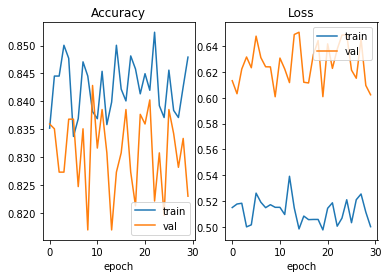

In [27]:
plt.subplot(1, 2, 1)
plt.plot(train_history4.history["acc"])
plt.plot(train_history4.history["val_acc"])
plt.title("Accuracy")
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel("epoch")

plt.subplot(1, 2, 2)
plt.plot(train_history4.history["loss"])
plt.plot(train_history4.history["val_loss"])
plt.title("Loss")
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel("epoch")